In [1]:
# Import dataset

import pandas as pd
import numpy as np

file_path = "./data/daily_HKO_GMT_ALL.csv"

raw = pd.read_csv(file_path, skiprows=2)

raw.columns = ["Year", "Month", "Day", "Value", "Completeness"]

# Date
raw["date"] = pd.to_datetime(dict(
    year=raw["Year"],
    month=raw["Month"],
    day=raw["Day"]
))

data = raw[["date", "Value", "Completeness"]].sort_values("date").reset_index(drop=True)

In [2]:
# NaN handling
data["Value"] = data["Value"].replace("***", np.nan)

data["Value"] = data["Value"].astype(float)

data.loc[data["Completeness"] == "#", "Value"] = np.nan

data = data.set_index("date").sort_index()
data["Value"] = data["Value"].interpolate(method="time", limit_direction="both")

ts = data["Value"]
print(ts.head(), ts.tail())

date
1968-01-03     5.3
1968-01-04     6.5
1968-01-05    11.7
1968-01-06    14.4
1968-01-07    15.2
Name: Value, dtype: float64 date
2025-10-27    22.0
2025-10-28    21.4
2025-10-29    21.7
2025-10-30    22.9
2025-10-31    22.3
Name: Value, dtype: float64


In [3]:
# Training set 1980/01/01-2023/12/31
# Validation set 2024/01/01-2024/12/31
# Testing set 2025/01/01-2025/10/30
train = ts.loc["1980-01-01":"2023-12-31"]
val   = ts.loc["2024-01-01":"2024-12-31"]
test  = ts.loc["2025-01-01":"2025-10-30"]

print("Train period:", train.index.min(), "->", train.index.max(), "len:", len(train))
print("Val   period:", val.index.min(),   "->", val.index.max(),   "len:", len(val))
print("Test  period:", test.index.min(),  "->", test.index.max(),  "len:", len(test))

Train period: 1980-01-01 00:00:00 -> 2023-12-31 00:00:00 len: 16071
Val   period: 2024-01-01 00:00:00 -> 2024-12-31 00:00:00 len: 366
Test  period: 2025-01-01 00:00:00 -> 2025-10-30 00:00:00 len: 303


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_values = train.values.reshape(-1, 1)
val_values   = val.values.reshape(-1, 1)
test_values  = test.values.reshape(-1, 1)

scaler.fit(train_values)           
train_scaled = scaler.transform(train_values)
val_scaled   = scaler.transform(val_values)
test_scaled  = scaler.transform(test_values)

In [5]:
import numpy as np

def create_sequences(data_array, seq_len):
    X, y = [], []
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i : i + seq_len])
        y.append(data_array[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 30  

X_train, y_train = create_sequences(train_scaled, seq_len)
X_val,   y_val   = create_sequences(val_scaled, seq_len)
X_test,  y_test  = create_sequences(test_scaled, seq_len)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:",   y_val.shape)
print("X_test: ", X_test.shape,  "y_test:",  y_test.shape)

X_train: (16041, 30, 1) y_train: (16041, 1)
X_val:   (336, 30, 1) y_val: (336, 1)
X_test:  (273, 30, 1) y_test: (273, 1)


In [6]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore

tf.random.set_seed(42)

In [24]:
# RNN Model
def build_rnn_model(seq_len, units=64):
    model = Sequential([
        SimpleRNN(units, input_shape=(seq_len, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

rnn_model = build_rnn_model(seq_len=seq_len, units=64)


history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - mae: 0.0475 - val_loss: 0.0027 - val_mae: 0.0411
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033 - mae: 0.0422 - val_loss: 0.0025 - val_mae: 0.0390
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - mae: 0.0419 - val_loss: 0.0026 - val_mae: 0.0400
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - mae: 0.0417 - val_loss: 0.0028 - val_mae: 0.0436
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - mae: 0.0415 - val_loss: 0.0031 - val_mae: 0.0466
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - mae: 0.0412 - val_loss: 0.0031 - val_mae: 0.0461
Epoch 7/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - mae: 0.0411 - val_loss: 0.0029 - val_mae: 0.0448
Epoch 8/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0029 - val_mae: 0.0440
Epoch 9/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

In [25]:
# LSTM Model
def build_lstm_model(seq_len, units=64, dropout_rate=0.2, stacked=True):
    model = Sequential()
    if stacked:
        model.add(LSTM(units, return_sequences=True, input_shape=(seq_len, 1)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units, return_sequences=False))
    else:
        model.add(LSTM(units, input_shape=(seq_len, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

lstm_model = build_lstm_model(seq_len=seq_len, units=64, dropout_rate=0.2, stacked=True)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0132 - mae: 0.0838 - val_loss: 0.0100 - val_mae: 0.0880
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0081 - mae: 0.0698 - val_loss: 0.0057 - val_mae: 0.0640
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0067 - mae: 0.0638 - val_loss: 0.0052 - val_mae: 0.0622
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0057 - mae: 0.0586 - val_loss: 0.0039 - val_mae: 0.0531
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0051 - mae: 0.0552 - val_loss: 0.0028 - val_mae: 0.0412
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0046 - mae: 0.0521 - val_loss: 0.0028 - val_mae: 0.0425
Epoch 7/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 8/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0041 - mae: 0.0492 - val_loss: 0.0030 - val_mae: 0.0450
Epoch 9/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/

In [26]:
# BILSTM model
def build_bilstm_model(seq_len, units=64, dropout_rate=0.2):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=(seq_len, 1)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

bilstm_model = build_bilstm_model(seq_len=seq_len, units=64, dropout_rate=0.2)

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/50


502/502 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0108 - mae: 0.0759 - val_loss: 0.0055 - val_mae: 0.0619
Epoch 2/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0063 - mae: 0.0617 - val_loss: 0.0046 - val_mae: 0.0577
Epoch 3/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0053 - mae: 0.0561 - val_loss: 0.0043 - val_mae: 0.0559
Epoch 4/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0048 - mae: 0.0532 - val_loss: 0.0030 - val_mae: 0.0445
Epoch 5/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0044 - mae: 0.0509 - val_loss: 0.0031 - val_mae: 0.0463
Epoch 6/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0041 - mae: 0.0489 - val_loss: 0.0033 - val_mae: 0.0492
Epoch 7/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0040 - mae: 0.0483 - val_loss: 0.0028 - val_mae: 0.0437
Epoch 8/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0039 - mae: 0.0472 - val_loss: 0.0033 - val_mae: 0.0490
Epoch 9/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss

In [10]:
best_val_mae = np.inf
best_cfg = None
best_model = None

for seq_len_ in [30, 60]:
    X_train_, y_train_ = create_sequences(train_scaled, seq_len_)
    X_val_,   y_val_   = create_sequences(val_scaled, seq_len_)

    for units_ in [32, 64]:
        model_ = build_lstm_model(seq_len_, units=units_, dropout_rate=0.2, stacked=True)
        history_ = model_.fit(
            X_train_, y_train_,
            validation_data=(X_val_, y_val_),
            epochs=60,
            batch_size=32,
            callbacks=callbacks,
            verbose=0
        )
        val_mae = min(history_.history["val_mae"])
        print(f"seq_len={seq_len_}, units={units_}, best val_mae={val_mae:.3f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_cfg = (seq_len_, units_)
            best_model = model_

print("Best config:", best_cfg, "Val MAE:", best_val_mae)

seq_len=30, units=32, best val_mae=0.040
seq_len=30, units=64, best val_mae=0.039
seq_len=60, units=32, best val_mae=0.042
seq_len=60, units=64, best val_mae=0.039
Best config: (30, 64) Val MAE: 0.03856145590543747


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, X, y, scaler):
    y_pred_scaled = model.predict(X)

    y_true = scaler.inverse_transform(y.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)

    return y_true.flatten(), y_pred.flatten(), mae, rmse

In [28]:
X_test, y_test = create_sequences(test_scaled, seq_len)

y_true_rnn,  y_pred_rnn,  mae_rnn,  rmse_rnn  = evaluate_model(rnn_model,  X_test, y_test, scaler)
y_true_lstm, y_pred_lstm, mae_lstm, rmse_lstm = evaluate_model(lstm_model, X_test, y_test, scaler)
y_true_bilstm, y_pred_bilstm, mae_bilstm, rmse_bilstm = evaluate_model(bilstm_model, X_test, y_test, scaler)

print("RNN  - Test MAE:  {:.3f} °C, RMSE: {:.3f} °C".format(mae_rnn,  rmse_rnn))
print("LSTM - Test MAE:  {:.3f} °C, RMSE: {:.3f} °C".format(mae_lstm, rmse_lstm))
print("BiLSTM - Test MAE: {:.3f} °C, RMSE: {:.3f} °C".format(mae_bilstm, rmse_bilstm))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RNN  - Test MAE:  0.980 °C, RMSE: 1.308 °C
LSTM - Test MAE:  0.956 °C, RMSE: 1.296 °C
BiLSTM - Test MAE: 0.963 °C, RMSE: 1.295 °C


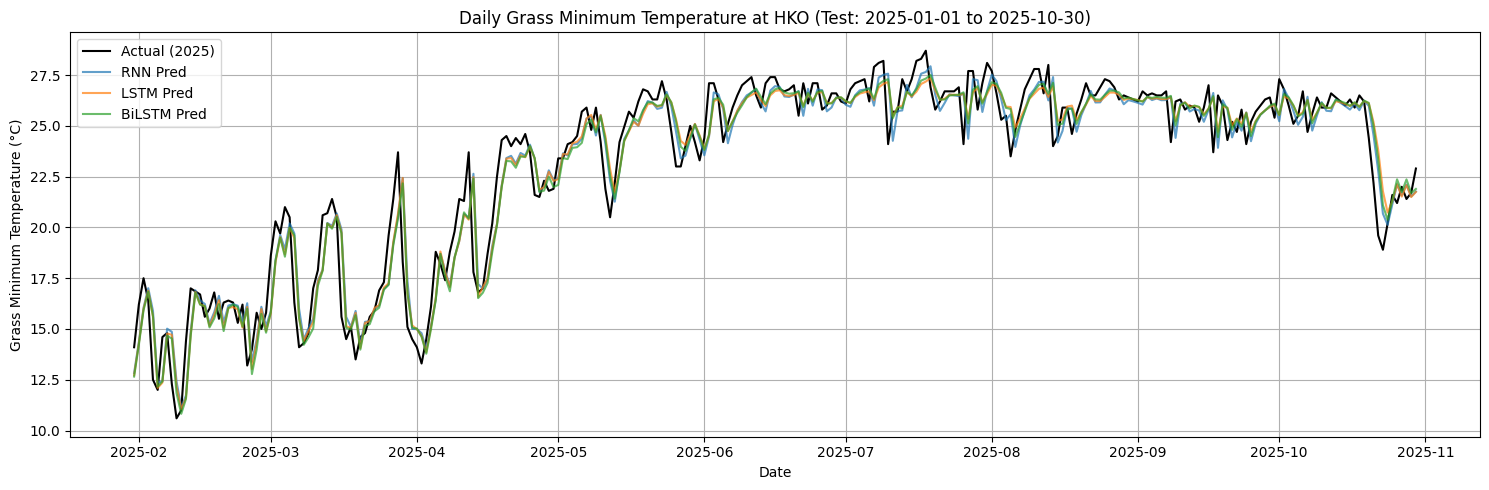

In [29]:
import matplotlib.pyplot as plt

test_dates = test.index[seq_len:] 

plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_true_bilstm, label="Actual (2025)", color="black") 
plt.plot(test_dates, y_pred_rnn,  label="RNN Pred",  alpha=0.7)
plt.plot(test_dates, y_pred_lstm, label="LSTM Pred", alpha=0.7)
plt.plot(test_dates, y_pred_bilstm, label="BiLSTM Pred", alpha=0.7)
plt.title("Daily Grass Minimum Temperature at HKO (Test: 2025-01-01 to 2025-10-30)")
plt.xlabel("Date")
plt.ylabel("Grass Minimum Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

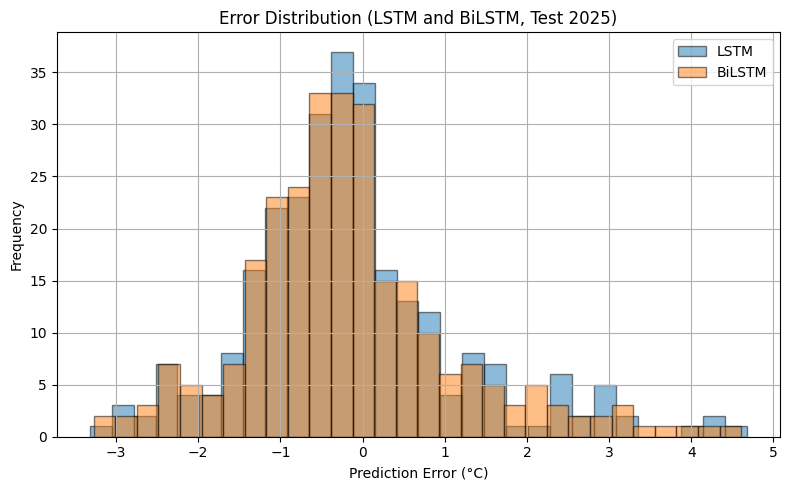

In [32]:
errors_lstm   = y_pred_lstm   - y_true_lstm
errors_bilstm = y_pred_bilstm - y_true_bilstm

plt.figure(figsize=(8, 5))
plt.hist(errors_lstm,   bins=30, edgecolor="k", alpha=0.5, label="LSTM")
plt.hist(errors_bilstm, bins=30, edgecolor="k", alpha=0.5, label="BiLSTM")
plt.title("Error Distribution (LSTM and BiLSTM, Test 2025)")
plt.xlabel("Prediction Error (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

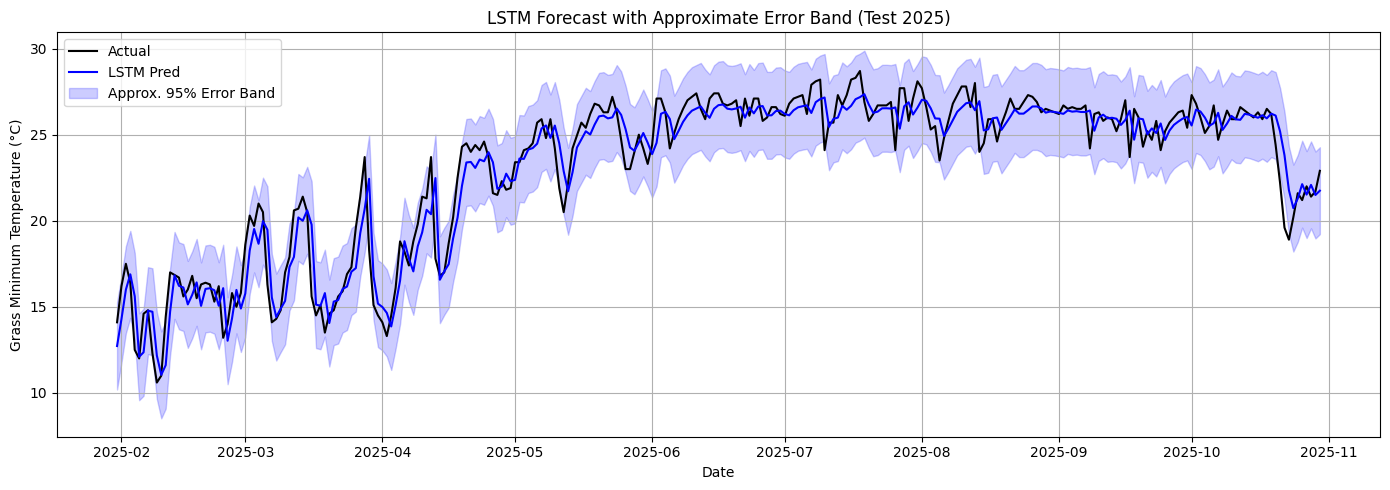

In [33]:
err_std = np.std(errors_lstm)
upper = y_pred_lstm + 1.96 * err_std
lower = y_pred_lstm - 1.96 * err_std

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true_lstm, label="Actual", color="black")
plt.plot(test_dates, y_pred_lstm, label="LSTM Pred", color="blue")
plt.fill_between(test_dates, lower, upper, color="blue", alpha=0.2,
                 label="Approx. 95% Error Band")
plt.title("LSTM Forecast with Approximate Error Band (Test 2025)")
plt.xlabel("Date")
plt.ylabel("Grass Minimum Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

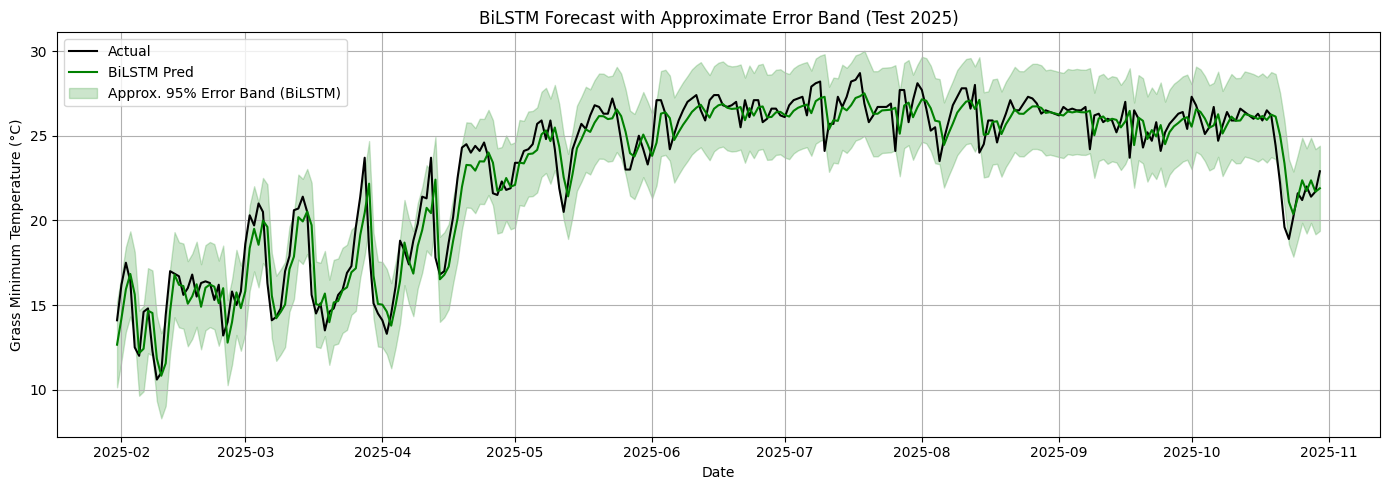

In [34]:
err_std_bilstm = np.std(errors_bilstm)
upper_bilstm = y_pred_bilstm + 1.96 * err_std_bilstm
lower_bilstm = y_pred_bilstm - 1.96 * err_std_bilstm

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true_bilstm, label="Actual", color="black")
plt.plot(test_dates, y_pred_bilstm, label="BiLSTM Pred", color="green")
plt.fill_between(test_dates, lower_bilstm, upper_bilstm, color="green", alpha=0.2,
                 label="Approx. 95% Error Band (BiLSTM)")
plt.title("BiLSTM Forecast with Approximate Error Band (Test 2025)")
plt.xlabel("Date")
plt.ylabel("Grass Minimum Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
abs_err = np.abs(errors_lstm)
idx_large = np.where(abs_err > np.percentile(abs_err, 95))[0]  

for i in idx_large[:10]: 
    print(test_dates[i].date(), 
          "True:", y_true_lstm[i], 
          "Pred:", y_pred_lstm[i],
          "Error:", errors_lstm[i])

2025-02-04 True: 12.5 Pred: 15.6119 Error: 3.1119003295898438
2025-02-24 True: 13.2 Pred: 16.08274 Error: 2.882740783691407
2025-03-01 True: 18.600000000000005 Pred: 15.76794 Error: -2.832060432434087
2025-03-06 True: 16.3 Pred: 19.477339 Error: 3.177338790893554
2025-03-16 True: 15.6 Pred: 19.769302 Error: 4.169302368164063
2025-03-28 True: 23.700000000000003 Pred: 20.684578 Error: -3.0154220581054716
2025-03-29 True: 18.300000000000004 Pred: 22.437199 Error: 4.137198638916011
2025-04-12 True: 23.700000000000003 Pred: 20.381033 Error: -3.318967056274417
2025-04-13 True: 17.8 Pred: 22.479574 Error: 4.67957420349121
2025-07-10 True: 24.100000000000005 Pred: 27.16017 Error: 3.0601696014404247


In [36]:
abs_err_bilstm = np.abs(errors_bilstm)
idx_large_bilstm = np.where(abs_err_bilstm > np.percentile(abs_err_bilstm, 95))[0]

print("\nTop BiLSTM error cases:")
for i in idx_large_bilstm[:10]:
    print(test_dates[i].date(),
          "True:", round(y_true_bilstm[i], 3),
          "Pred:", round(y_pred_bilstm[i], 3),
          "Error:", round(errors_bilstm[i], 3))


Top BiLSTM error cases:
2025-02-04 True: 12.5 Pred: 15.627 Error: 3.127
2025-02-11 True: 14.4 Pred: 11.555 Error: -2.845
2025-02-24 True: 13.2 Pred: 15.998 Error: 2.798
2025-03-01 True: 18.6 Pred: 15.814 Error: -2.786
2025-03-06 True: 16.3 Pred: 19.611 Error: 3.311
2025-03-16 True: 15.6 Pred: 19.713 Error: 4.113
2025-03-28 True: 23.7 Pred: 20.442 Error: -3.258
2025-03-29 True: 18.3 Pred: 22.169 Error: 3.869
2025-04-12 True: 23.7 Pred: 20.428 Error: -3.272
2025-04-13 True: 17.8 Pred: 22.407 Error: 4.607


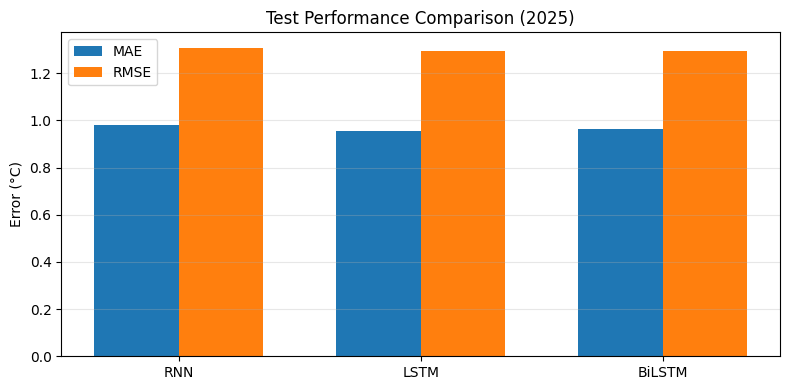

In [37]:
# Compare MAE and RMSE across models
labels = ["RNN", "LSTM", "BiLSTM"]
maes   = [mae_rnn, mae_lstm, mae_bilstm]
rmses  = [rmse_rnn, rmse_lstm, rmse_bilstm]

plt.figure(figsize=(8, 4))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, maes,  width, label="MAE")
plt.bar(x + width/2, rmses, width, label="RMSE")
plt.xticks(x, labels)
plt.ylabel("Error (°C)")
plt.title("Test Performance Comparison (2025)")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()